0.1910296742050266
beta [[ 1.00133156 -0.43682379]
 [-0.43682379  2.15142927]]
Le bêta haussier est : [[ 1.00258398 -0.76109042]
 [-0.76109042  4.99533556]]
[[ 1.00275482 -0.68688299]
 [-0.68688299  4.52851673]]
beta [[ 1.00134048 -0.1648666 ]
 [-0.1648666   2.24681435]]
Le bêta haussier est : [[ 1.00247525 -0.17902075]
 [-0.17902075  5.24260477]]
[[ 1.00293255 -0.08262275]
 [-0.08262275  4.11909154]]
beta [[ 1.00133156 -0.43682379]
 [-0.43682379  2.15142927]]
Le bêta haussier est : [[ 1.00258398 -0.76109042]
 [-0.76109042  4.99533556]]
[[ 1.00275482 -0.68688299]
 [-0.68688299  4.52851673]]
beta [[ 1.00133156 -0.43121109]
 [-0.43121109  2.35748368]]
Le bêta haussier est : [[ 1.00252525 -0.77035692]
 [-0.77035692  5.55453448]]
[[ 1.00284091 -0.62065523]
 [-0.62065523  4.99112805]]
Le ratio de sharpe est  {'MSFT': 0.3562096387745911}
-0.14104803545775413
beta [[1.00133156 0.00503904]
 [0.00503904 1.96909833]]
Le bêta haussier est : [[ 1.00258398 -0.24005002]
 [-0.24005002  4.71971061]]
[

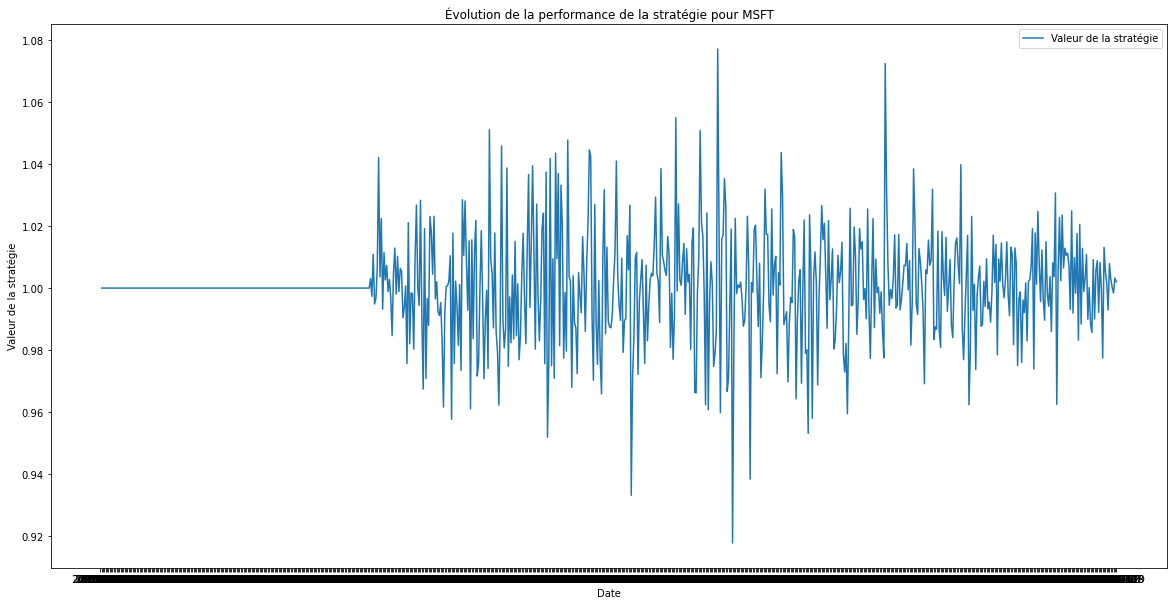

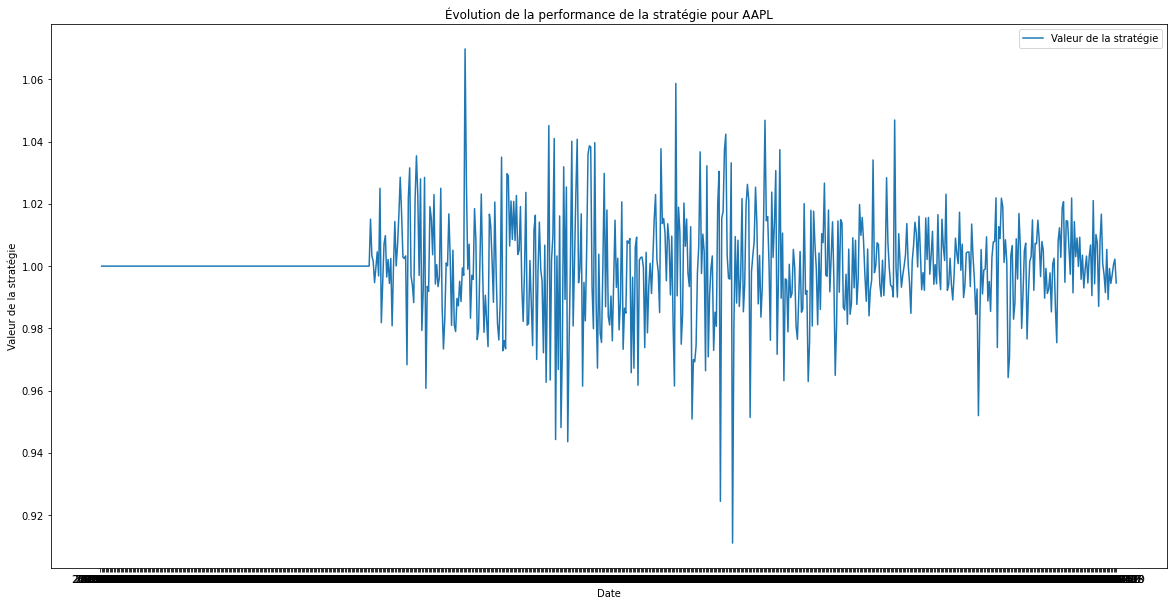

In [1]:
# Importation des bibliothèques
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import numpy as np
import os

class Backtester:
    # Initialisation de la classe
    def __init__(self, strategy):
        self.strategy = strategy
        
    # Compute : récupération, stockage des données et application de la stratégie
    def compute(self, symbols, start_date, end_date):
        # Déclaration des bibliothèque
        self.df_market={}  # Data frame pour les indices de marché
        self.symbols={} # Data frame pour les symboles
        self.df={} # Data frame pour les données des titres
        self.market_up = {}
        self.market_down = {}

        # Récupération et stockage local des données : Indices de marché
        self.markets = ['^GSPC','^FCHI','^GSPC', 'ACWI']  # Symbole pour l'indice S&P 500, euro, CAC40, World
        for market in self.markets:
            index_name = f"{market, start_date, end_date}_data.csv"
            if os.path.exists(index_name):
                market_data = pd.read_csv(index_name, index_col=0)
            else:
                market_data =yf.download(market, start=start_date, end=end_date)
                market_data.to_csv(index_name)
            self.df_market[market]=pd.DataFrame(market_data)
            # Déterminer les rendements positives et négatives de l'indice
            self.df_market[market]['positive'] = np.where(self.df_market[market]['Close'].pct_change() > 0, self.df_market[market]['Close'].pct_change(), np.nan)
            self.df_market[market]['negative'] = np.where(self.df_market[market]['Close'].pct_change() < 0, self.df_market[market]['Close'].pct_change(), np.nan)
            self.market_up[market] = self.df_market[market]['Close'].pct_change() > 0
            self.market_down[market] =  self.df_market[market]['Close'].pct_change() < 0

        for symbol in symbols:
            # Récupération des symboles
            self.symbols[symbol] = symbol
            # Récupération et stockage local des données des titres
            file_name = f"{symbol, start_date, end_date}_data.csv"
            if os.path.exists(file_name):
                data = pd.read_csv(file_name, index_col=0)
            else:
                data = yf.download(symbol, start=start_date, end=end_date)
                data.to_csv(file_name)
            self.df[symbol] = pd.DataFrame(data)
            # Calcul des résultats pour la stratégie
            self.strategy(self.df[symbol])
        return 
       
    # Summary : indicateurs de performance de la stratégie
    def summary(self):
        # Déclaration des dictionnaires
        kurtosis = {}
        cumulative_strategy_return = {}
        volatility = {}
        annual_volatility = {}
        beta = {}
        beta_haussier={}
        beta_baissier={}
        max_drawdown = {}
        skewness = {}
        annual_strategy_return = {}
        returns_up = {}
        returns_down = {}
        sharpe_ratio= {}
        # Rendements
        
        for symbol in self.symbols:
            #Calcul des rendements du titres 
            self.df[symbol]['asset_returns']=self.df[symbol]['Close'].pct_change()
            #Calcul des rendements de la stratégie 
            self.df[symbol]['strategy_returns']=self.df[symbol]['asset_returns']*self.df[symbol]['Position'].shift(1)
            #Calcul des rendements cumulatifs 
            cumulative_strategy_return[symbol]=(1+self.df[symbol]['strategy_returns'].dropna()).cumprod()-1
            self.df[symbol]['cumulative_strategy_return']=cumulative_strategy_return[symbol]
            print(cumulative_strategy_return[symbol].iloc[-1])
            #Rendement moyen annuel 
            annual_strategy_return[symbol]=self.df[symbol]['strategy_returns'].mean()*252
            # Volatilité
            # Volatilité quotidienne 
            volatility[symbol] =np.std(self.df[symbol]['strategy_returns'])
            # Volatilité annuelle 
            annual_volatility[symbol] = volatility[symbol]*np.sqrt(252)
            # Bêta
            beta[symbol] = {}
            beta_haussier[symbol] = {}
            beta_baissier[symbol] = {}
            returns_up[symbol] = {}
            returns_down[symbol] = {}
            sharpe_ratio[symbol] = {}

            for market in self.markets:
                
                # Affecter les rendements à de nouvelles variables
                action_returns = self.df[symbol]['strategy_returns'].dropna()
                marche_returns = self.df_market[market]['Close'].pct_change().dropna()
                # Supprimer les dates qui ne sont pas communes aux deux séries
                common_dates = action_returns.index.intersection(marche_returns.index)
                action_returns = action_returns.loc[common_dates]
                marche_returns = marche_returns.loc[common_dates]

                beta[symbol][market]=(np.cov(marche_returns,action_returns))/(np.var(marche_returns))
                print("beta" , beta[symbol][market])
                 # Filtrez les rendements de l'actif et du marché pour inclure uniquement les périodes de hausse du marché
                self.df[symbol]['Market_up'] = self.df_market[market]['positive']
                self.df[symbol]['Market_down'] = self.df_market[market]['negative']
                returns_up[symbol][market] = self.df[symbol].loc[~self.df[symbol]['Market_up'].isna(), 'strategy_returns']
                returns_down[symbol][market] = self.df[symbol].loc[~self.df[symbol]['Market_down'].isna(), 'strategy_returns']

                #beta[symbol][market]=(np.cov(self.df_market[market]['Close'].pct_change().dropna(),self.df[symbol]['strategy_returns'].dropna()))/(np.var(self.df_market[market]['Close'].pct_change().dropna()))
                # Bêta haussier
                beta_haussier[symbol][market]= (np.cov(self.df[symbol]['Market_up'].dropna(),returns_up[symbol][market]))/(np.var(self.df[symbol]['Market_up'].dropna()))
                print("Le bêta haussier est :", beta_haussier[symbol][market])
                # Bêta baissier
                beta_baissier[symbol][market]= (np.cov(self.df[symbol]['Market_down'].dropna(),returns_down[symbol][market]))/(np.var(self.df[symbol]['Market_down'].dropna()))
                print(beta_baissier[symbol][market])

            # Drawdown maximal
            self.df[symbol]['drawdowns'] = self.df[symbol]['strategy_returns'] - self.df[symbol]['strategy_returns'].cummax()
            max_drawdown[symbol] = self.df[symbol]['drawdowns'].min()

            # Kurtosis
            kurtosis[symbol] = (self.df[symbol]['strategy_returns'].dropna()).kurtosis()
            #print(kurtosis[symbol])

            # Skewness
            skewness[symbol] = self.df[symbol]['drawdowns'].min()
       
           # Ratio de Sharpe
            sharpe_ratio[symbol] = annual_strategy_return[symbol]/ annual_volatility[symbol]
            print("Le ratio de sharpe est de", sharpe_ratio)
           
           # Downside risk (DSR)
           # Ratio de sortino
        return
      
    # Plot : Visualisation des résultats
    def plot(self):
        #Graphique des positions + cours du prix
        # Calculer la valeur de la stratégie en base 100
        for symbol in self.symbols:
            self.df[symbol]['strategy_value'] = (1 + self.df[symbol]['strategy_returns'])

        # Tracer graphiquement l'évolution de la valeur de la stratégie
            plt.figure(figsize=(20, 10))
            plt.plot(self.df[symbol]['strategy_value'], label='Valeur de la stratégie')
            plt.title(f"Évolution de la performance de la stratégie pour {symbol}")
            plt.xlabel('Date')
            plt.ylabel('Valeur de la stratégie')
            plt.legend()
            plt.show()
        return

# Exemple de stratégie
def simple_strategy(data):
    # Exemple de stratégie simple : achat lorsque la moyenne mobile sur 50 jours est supérieure à la moyenne mobile sur 200 jours, et vente dans le cas contraire
    data['50_MA'] = data['Close'].rolling(window=50).mean()
    data['200_MA'] = data['Close'].rolling(window=200).mean()
    data['Position'] = 0
    data.loc[data['50_MA'] > data['200_MA'], 'Position'] = 1  # Achat
    data.loc[data['50_MA'] < data['200_MA'], 'Position'] = -1  # Vente
    return data['Position']

# Exemple d'utilisation du backtester avec la stratégie simple
Backteste = Backtester(strategy=simple_strategy)
Backteste.compute(["MSFT", "AAPL"], "2021-01-01","2023-12-31")
print(Backteste.summary())
Backteste.plot()
